In [87]:
# Creating ElasticSearch connector
#
import elasticsearch
import elasticsearch.helpers

es_user = 'admin'
es_pass = 'admin'
es_host = 'docker.for.mac.localhost'

# connector to ElasticSearch
es = elasticsearch.Elasticsearch(['http://%s:%s@%s:9200' % (es_user, es_pass, es_host)], timeout=600, scroll='2m')

# check status
if not es.ping():
    raise Exception("Connection failed")

In [12]:
# example 1:
# retrieve the number of documents satisfying the query criteria
#
# an example query -- search for keyword 'cancer' in annotations
query_body = {
    "query": {
        "match": {
            "nlp.text": "cancer"}
    }
}

index_to_query = 'nifi_ann_bioyodie'


documents = es.search(index=index_to_query, body=query_body)

print(documents['hits']['total'])

1017


In [13]:
# example 2:
# - retrieve all the documents matching the query criteria 
# - calculate the CUI codes occurencies
# - visualize the results

# query the elasticsearch
results = elasticsearch.helpers.scan(es, index=index_to_query, query=query_body)

# calculate the occurencies
cui_occ = {}
tui_arr = {}
for item in results:
    #cui = (item['_source']['nlp.inst'], item['_source']['nlp.text'])
    cui = item['_source']['nlp.inst']
    if cui not in cui_occ: 
        cui_occ[cui] = 1
    else:
        cui_occ[cui] += 1
        
    tui = item['_source']['nlp.TUI']
    if tui not in tui_arr:
         tui_arr[tui] = set()
    tui_arr[tui].add(cui)
    
print(tui_arr)

{'T191': {'C0279530', 'C0153567', 'C0242379', 'C0238301', 'C0007134', 'C0153676', 'C0153633', 'C0740457', 'C0220647', 'C0005684', 'C0042237', 'C0153392', 'C0024623', 'C0855005', 'C0007102', 'C1959584', 'C0278484', 'C0280249', 'C0007114', 'C0206698', 'C0149925', 'C0376358', 'C0007131', 'C0007847', 'C0278996', 'C0278688', 'C2939420', 'C0006142', 'C0005695', 'C0746787', 'C0751623', 'C0040136', 'C1707251', 'C0936223', 'C0235974', 'C0029925', 'C0278488', 'C0278479', 'C0220630', 'C0006826'}, 'T061': {'C0741886', 'C0920425', 'C0920424', 'C1511300', 'C0281185'}, 'T060': {'C0554837', 'C0027646'}}


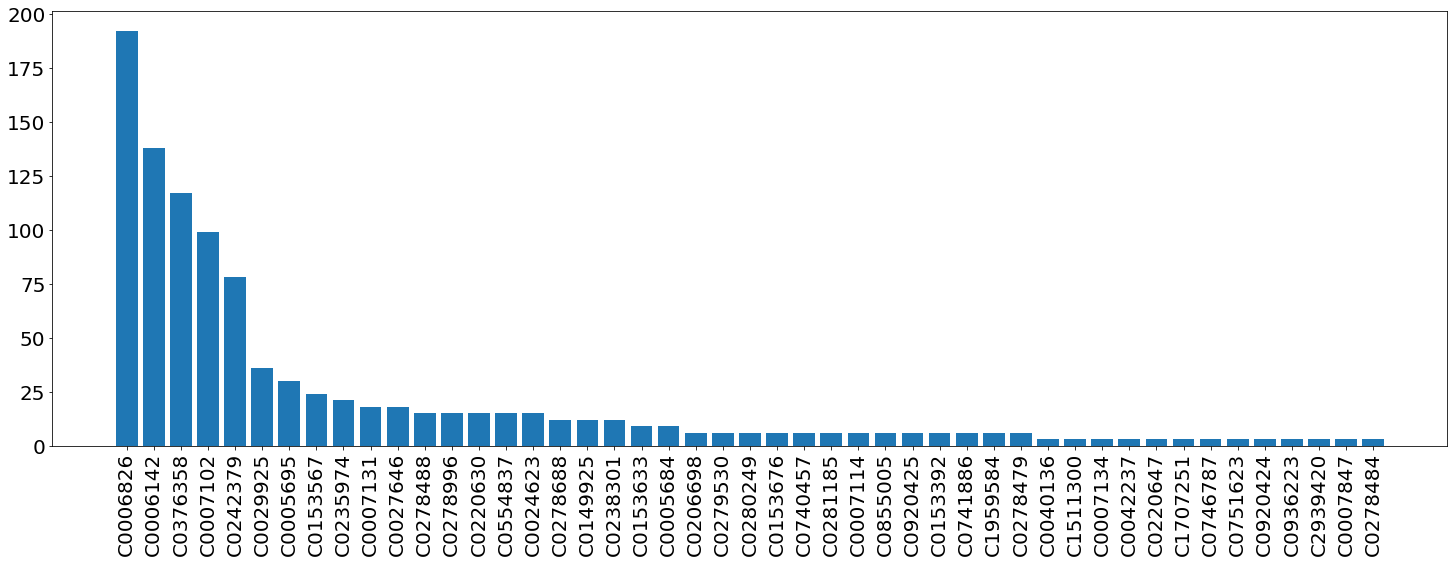

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

cui_names = []
cui_counts = []

for cui, cnt in sorted(cui_occ.items(), key=lambda kv: kv[1], reverse=True):
    cui_names.append(cui)
    cui_counts.append(cnt)

# display the results
plt.figure(figsize=(25,8))

plt.bar(range(len(cui_names)), list(cui_counts), align='center')
plt.xticks(range(len(cui_occ)), list(cui_names), rotation=90)

plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

plt.show()

In [15]:
import networkx as nx
# graph stuff

In [88]:
# read the records from PostgreSQL and store them as pandas
#
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql

# connector config
pg_user = 'test'
pg_pass = 'test'
pg_host = es_host
pg_port = 5555
pg_db_name = "db_samples"


# open PostgreSQL connector
conn = pg.connect(database=pg_db_name,user=pg_user, password=pg_pass, host=pg_host, port=pg_port)


In [86]:
# example: read the DB and create pandas data frame
df = pd.read_sql('SELECT patient, doc_id, created FROM observations WHERE doc_id IS NOT NULL', conn)
df.head()

,patient,doc_id,created
0,ab2db5cf-b174-4939-8dfa-ebd331a9d989,4826,2021-10-14 14:28:34.192528
1,40fb7860-bf60-453a-863b-a621d5839385,4577,2022-12-19 22:23:43.168528
2,03d952f4-b297-4a34-9e67-431afa14ed56,4841,2020-03-23 10:35:04.000528
3,f9d5da52-e9bc-416d-884a-1f844d2f6092,4724,2021-02-24 14:25:16.595728
4,b23bc2b1-3260-4e6a-a7b5-65fdbc3977aa,4598,2021-02-06 13:18:51.222928


In [82]:
# example: create pandas data frame from the ES results
#

# need to re-query ES to fetch the results
results = elasticsearch.helpers.scan(es, index=index_to_query, query=query_body)

# create a data frame from the results
ddf = pd.DataFrame.from_dict([item['_source'] for item in results])
ddf.head()

,meta.cid,meta.code,meta.created,meta.date,meta.description,meta.doc_id,meta.encounter,meta.patient,meta.type,meta.units,...,nlp.inst,nlp.inst_full,nlp.language,nlp.set,nlp.start_idx,nlp.start_node_id,nlp.string_orig,nlp.text,nlp.tui_full,nlp.type
0,1023,2069-3,1619306328659,14805,Chloride,4823,d8e482b5-6b33-40ad-bd57-a3363d2b78d6,edad21d5-7bcc-492a-9177-34b13b402a0d,numeric,mmol/L,...,C0007102,http://linkedlifedata.com/resource/umls/id/C00...,,Bio,2584,4283,colon cancer,colon cancer,http://linkedlifedata.com/resource/semanticnet...,Mention
1,1023,2069-3,1619306328659,14805,Chloride,4823,d8e482b5-6b33-40ad-bd57-a3363d2b78d6,edad21d5-7bcc-492a-9177-34b13b402a0d,numeric,mmol/L,...,C0007102,http://linkedlifedata.com/resource/umls/id/C00...,,Bio,2502,4275,colon cancer,colon cancer,http://linkedlifedata.com/resource/semanticnet...,Disease
2,1023,2069-3,1619306328659,14805,Chloride,4823,d8e482b5-6b33-40ad-bd57-a3363d2b78d6,edad21d5-7bcc-492a-9177-34b13b402a0d,numeric,mmol/L,...,C0206698,http://linkedlifedata.com/resource/umls/id/C02...,,Bio,2601,4287,bile duct cancer,bile duct cancer,http://linkedlifedata.com/resource/semanticnet...,Disease
3,1023,2069-3,1619306328659,14805,Chloride,4823,d8e482b5-6b33-40ad-bd57-a3363d2b78d6,edad21d5-7bcc-492a-9177-34b13b402a0d,numeric,mmol/L,...,C0007102,http://linkedlifedata.com/resource/umls/id/C00...,,Bio,2642,4291,colon cancer,colon cancer,http://linkedlifedata.com/resource/semanticnet...,Neoplastic_Process
4,15,8462-4,1559165152048,6448,Diastolic Blood Pressure,4367,2452cf09-021b-4586-9e33-59d7d2242f31,b9f5a11b-211d-4ced-b3ba-12012c83b937,numeric,mmHg,...,C0153633,http://linkedlifedata.com/resource/umls/id/C01...,,Bio,2359,4181,brain cancer,brain cancer,http://linkedlifedata.com/resource/semanticnet...,Disease


In [76]:
# select only a subset of columns and perform filtering based on TUI and CUI
ddx = ddf.filter(items=['meta.patient', 'nlp.type', 'nlp.text', 'nlp.inst', 'nlp.TUI'])
rows = ddx.loc[(ddx['nlp.TUI'] == 'T191') & (ddx['nlp.inst'] == 'C0007102')]

print(rows[0:10])

                            meta.patient            nlp.type      nlp.text  \
0   edad21d5-7bcc-492a-9177-34b13b402a0d             Mention  colon cancer   
1   edad21d5-7bcc-492a-9177-34b13b402a0d             Disease  colon cancer   
3   edad21d5-7bcc-492a-9177-34b13b402a0d  Neoplastic_Process  colon cancer   
30  edad21d5-7bcc-492a-9177-34b13b402a0d  Neoplastic_Process  colon cancer   
33  9929044f-1f43-4453-b2c0-a2f45dcdd4be             Mention  colon cancer   
35  1594714e-d8fb-4fa7-9d62-256c4585ea30             Mention  colon cancer   
39  1594714e-d8fb-4fa7-9d62-256c4585ea30  Neoplastic_Process  colon cancer   
44  9929044f-1f43-4453-b2c0-a2f45dcdd4be             Disease  colon cancer   
50  84dd6378-2ddc-44b6-9292-2a4461bcef53             Disease  colon cancer   
95  7f17a8e2-339e-48c6-9b8e-1db236ba9038  Neoplastic_Process  Colon cancer   

    nlp.inst nlp.TUI  
0   C0007102    T191  
1   C0007102    T191  
3   C0007102    T191  
30  C0007102    T191  
33  C0007102    T191  
35 